# Timeseries forecasting for weather prediction

**Authors:** [Prabhanshu Attri](https://prabhanshu.com/github), [Yashika Sharma](https://github.com/yashika51), [Kristi Takach](https://github.com/ktakattack)
<br>
**Date created:** 2020/06/23  <br>
**Last modified:** 2020/06/25  <br>
**Description:** This notebook demonstrates how to use the ```timeseries_dataset_from_array()``` for data processing using a LSTM model.


## Climate Data Time-Series

Location: Weather Station, Max Planck Institute for Biogeochemistry in Jena, Germany
Time-frame: Jan 10, 2009 - December 31, 2016

Index  |   Features         |   Format                |   Description
-------|--------------------|-------------------------|-----------------------
1      |   Date Time        |   01.01.2009 00:10:00   |   Date-time reference
2      |   p (mbar)         |   996.52                |   The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3      |   T (degC)         |   -8.02                 |   Temperature in Celsius
4      |   Tpot (K)         |   265.4                 |   Temperature in Kelvin
5      |   Tdew (degC)      |   -8.9                  |   Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses. 
6      |   rh (%)           |   93.3                  |   Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects. 
7      |   VPmax (mbar)     |   3.33                  |   Saturation vapor pressure
8      |   VPact (mbar)     |   3.11                  |   Vapor pressure
9      |   VPdef (mbar)     |   0.22                  |   Vapor pressure deficit
10     |   sh (g/kg)        |   1.94                  |   Specific humidity
11     |   H2OC (mmol/mol)  |   3.12                  |   Water vapor concentration
12     |   rho (g/m ** 3)   |   1307.75               |   Airtight
13     |   wv (m/s)         |   1.03                  |   Wind speed 
14     |   max. wv (m/s)    |   1.75                  |   Maximum wind speed
15     |   wd (deg)         |   152.3                 |   Wind direction in degrees  


Source: https://www.bgc-jena.mpg.de/wetter/

## Setup


As of 25th June, 2020, `timeseries_dataset_from_array()` is available with TensorFlow nightly. Also, Keras might throw an error while training if the Keras version is not 2.4.0.

The following cell will help us to install these requirements. If this doesn't work, then try uninstalling Tensorflow and Keras using the following command.

```
!pip uninstall tf-nightly keras -y
```


In [1]:
!pip install 'tf-nightly==2.3.0.dev20200623'
!pip install 'keras==2.4.0'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


**Note**: Please restart the runtime using the button above in order to load installed Tensorflow and Keras versions.

In [2]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.activations import sigmoid, softmax
from keras.optimizers import Adagrad,Adam
from keras.callbacks import ModelCheckpoint

print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

Tensorflow version: 2.3.0-dev20200623
Keras version: 2.4.0


Using TensorFlow backend.


#### Enable GPU

The memory of a graphics card will be fully allocated to process if we don't limit the gpu growth. The model needs only the fraction of memory for training and prediction.

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = False
session = InteractiveSession(config=config)


SEED_VALUE = 10

tf.random.set_seed(SEED_VALUE)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Dataset

We are working with an open dataset. The dataset consists of 15 columns including Pressure, Temperature and Humidity. The obsevation for each feature is taken once in 10 minutes that is 6 times an hour.

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [5]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Raw Visualizations

We are visualizing the features against Time to check the sequence and patterns.

In [6]:
titles = ['Pressure', "Temperature", "Temperature in Kelvin", "Temperature (dew point)", "Relative Humidity", "Saturation vapor pressure", "Vapor pressure", "Vapor pressure deficit", "Specific humidity", "Water vapor concentration", "Airtight", "Wind speed", "Maximum wind speed", "Wind direction in degrees"]

feature_keys = ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"]

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

date_time_key = 'Date Time'

In [7]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(
        15, 20), dpi=80, facecolor='w', edgecolor='k')
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax=axes[i // 2, i % 2], color=c,
                         title='{} - {}'.format(titles[i], key), rot=25)
        ax.legend([titles[i]])
    plt.tight_layout()

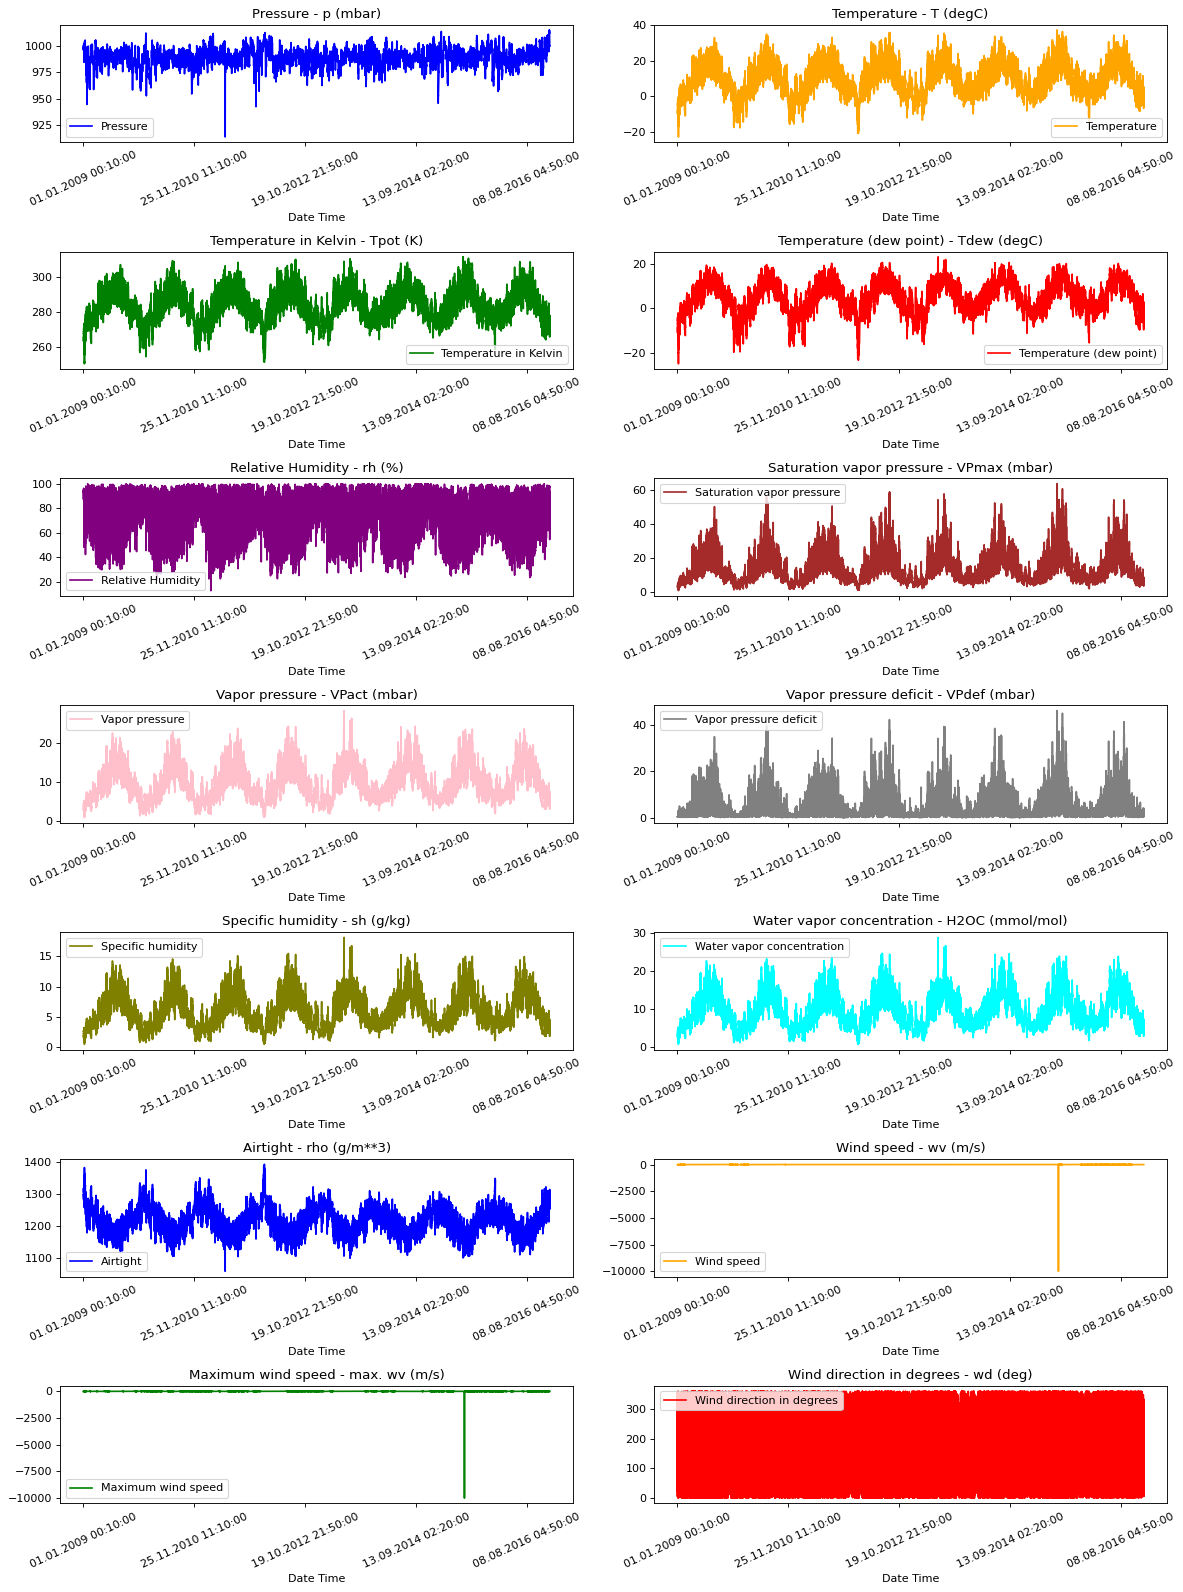

In [8]:
show_raw_visualization(df)

This heat map shows the correlation between different features.


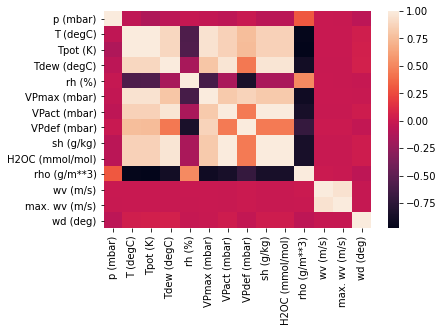

In [9]:
corr = df.corr()
sns.heatmap(corr)

The input data will include pressure, temperature (in Celsius) and specific humidity. The below line graphs show each feature graphed by hour, month and year.


<Figure size 432x288 with 0 Axes>

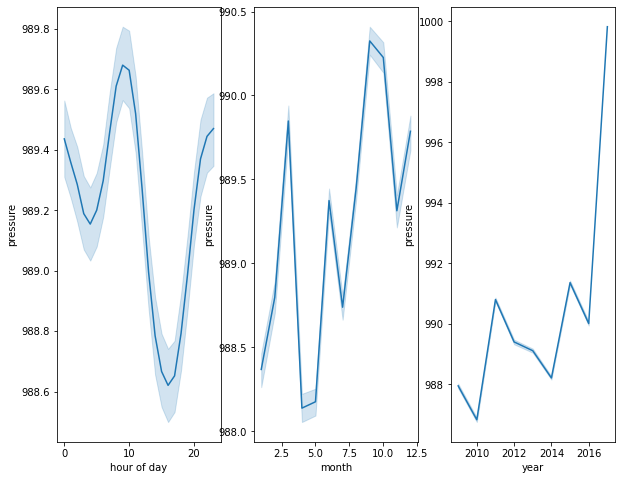

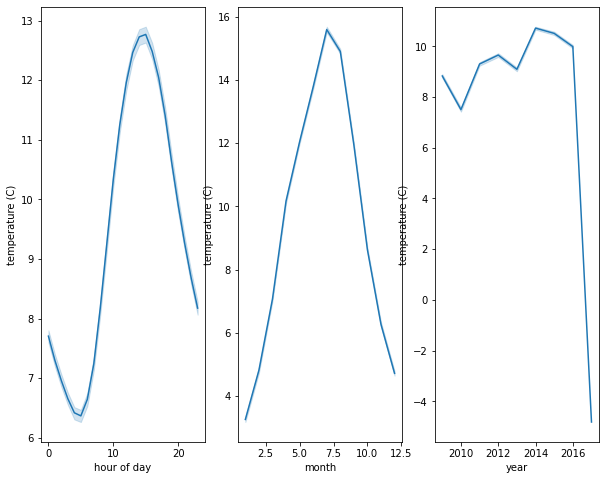

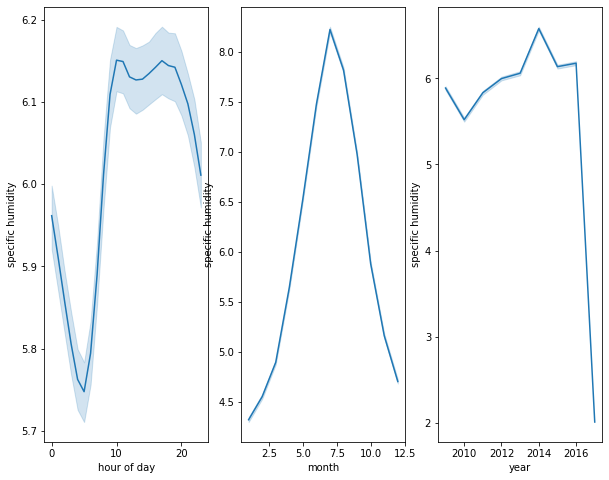

In [10]:
def show_line_graphs(df):
  df2=df.copy()
  df2.head()
  df2['Date Time']=pd.to_datetime(df2['Date Time'])
  df2.index=df2['Date Time']

  fig = plt.figure()

  #row 1 of pressure line graphs
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,8))
  sns.lineplot(x=df2.index.hour,y=df2['p (mbar)'], ax=ax1)
  ax1.set(xlabel= "hour of day", ylabel = "pressure")

  sns.lineplot(x=df2.index.month, y=df2['p (mbar)'], ax=ax2)
  ax2.set(xlabel= "month", ylabel = "pressure")

  sns.lineplot(x=df2.index.year, y=df2['p (mbar)'], ax=ax3)
  ax3.set(xlabel= "year", ylabel = "pressure")

  #row 2 of temperature line graphs
  fig, ( ax4, ax5, ax6) = plt.subplots(1,3, figsize=(10,8))
  sns.lineplot(x=df2.index.hour,y=df2['T (degC)'], ax=ax4)
  ax4.set(xlabel= "hour of day", ylabel = "temperature (C)")

  sns.lineplot(x=df2.index.month,y=df2['T (degC)'], ax=ax5)
  ax5.set(xlabel= "month", ylabel = "temperature (C)")

  sns.lineplot(x=df2.index.year,y=df2['T (degC)'], ax=ax6)
  ax6.set(xlabel= "year", ylabel = "temperature (C)")

  #row 3 of humidity line graphs
  fig, (ax7, ax8, ax9) = plt.subplots(1,3, figsize=(10,8))
  sns.lineplot(x=df2.index.hour,y=df2['sh (g/kg)'], ax=ax7)
  ax7.set(xlabel= "hour of day", ylabel = "specific humidity")

  sns.lineplot(x=df2.index.month,y=df2['sh (g/kg)'], ax=ax8)
  ax8.set(xlabel= "month", ylabel = "specific humidity")

  sns.lineplot(x=df2.index.year,y=df2['sh (g/kg)'], ax=ax9)
  ax9.set(xlabel= "year", ylabel = "specific humidity")

  plt.show()

show_line_graphs(df)

## Data Preprocessing

Here we are picking 300000 data points for training. The observation is recorded every 10 mins, that means 6 times in an hour. Thus STEP is equal to 6. We are tracking data fom past 720 timestamps(i.e. 720/6=120 hours) and this will be used to predict the temperature after 72 timestamps(i.e. 76/6=12 hours).

Raw data is normalized using a z score formula. Since every feature has values with varying ranges, normalization is done to confine the values in a range of [0,1] before training a neural network.
It is done by subtracting the mean and dividing by the standard deviation of each feature

In [11]:
TRAIN_SPLIT = 300000
PAST = 720
FUTURE = 72
STEP = 6
LEARNING_RATE = 0.001
VALIDATION_STEPS = 50

BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10

STEPS_PER_EPOCH= TRAIN_SPLIT / 300

In [12]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean)/data_std


def preprocess_data(data, train_split=TRAIN_SPLIT, past=PAST, future=FUTURE, step=STEP):
    X_train, y_train, X_val, y_val = [], [], [], []
    data = normalize(data, train_split)
    train_data = data[:train_split]
    val_data = data[train_split:]
    
    batch_size = BATCH_SIZE

    sequence_length = int(past/step)

    start = past + future
    end = start + batch_size

    X_train = tf.keras.preprocessing.timeseries_dataset_from_array(
        train_data, targets=None, sequence_length=sequence_length, sampling_rate=step, batch_size=batch_size)

    y_train = data[:, 1]
    y_train = y_train[start:end]

    batch_size = len(data) - train_split - past - future
    X_val = tf.keras.preprocessing.timeseries_dataset_from_array(
        val_data, targets=None, sequence_length=sequence_length, sampling_rate=step, batch_size=batch_size)

    start = train_split + past + future
    end = len(data) - past

    y_val = data[:, 1]
    y_val = y_val[start:]

    X_train = np.stack(list(X_train)[0])
    X_val = np.stack(list(X_val)[0])
    return [X_train, y_train, X_val, y_val]

We will be using selecting few parameters from the dataset to avoid complete memory(RAM) usage. Moreover, we can see from the correlation heatmap, few parameters like Relative Humidity and Specific Humidity are redundent.

The selected parameters are 'p (mbar)', 'T (degC)', 'VPdef (mbar)', 'sh (g/kg)', and 'rho (g/m**3)'

In [13]:
selected_features = [feature_keys[i] for i in [0,1,5,7,8,10,11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [14]:
x_train, y_train, x_val, y_val = preprocess_data(features.values)

In [15]:
# converts data from numpy to RepeartDataset
train_repeat_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_repeat_data = train_repeat_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_repeat_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_repeat_data = val_repeat_data.batch(BATCH_SIZE).repeat()

## Training


We will be running the model training for 10 epochs. A RNN (recurrent neural network) is used to record sequences and track the pattern. Since the timeseries data is nothing but a long sequence of values, RNN will track and find patterns from this. LSTM is a type of RNN network which solves the problem of vanishing gradients and is well suited for our problem.
GRU is another type of RNN network and works very similar to the LSTM.

We are using Adagrad optimizer with an inverse time decay learning rate.
Overall three layers are stacked up to prepare the model.

1. LSTM: To record sequences
2. Dropout: To avoid overfitting
3. Dense: Final classification layer

Finally we compile our model and the loss chosen is mean_squared_error.

In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  LEARNING_RATE,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

adagrad_opt = Adagrad(lr_schedule)

In [17]:
model = Sequential()
model.add(LSTM(32,input_shape=x_train.shape[-2:]))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer=adagrad_opt, loss='mean_squared_error')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


Saving a checkpoint will allow us to load the weights from a trained model so that we don't have to train the model again and again whenever new runtime is started.


In [19]:
path_checkpoint = 'model_checkpoint.keras'

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_weights_only=True,
                                  save_best_only=True)

history = model.fit(train_repeat_data,
                    epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_repeat_data,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[callback_checkpoint])

Epoch 1/10
199/200 [============================>.] - ETA: 0s - loss: 1.4931
Epoch 00001: val_loss improved from inf to 0.38745, saving model to model_checkpoint.keras
200/200 [==============================] - 2s 11ms/step - loss: 1.4892 - val_loss: 0.3874
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.6805
Epoch 00002: val_loss did not improve from 0.38745
200/200 [==============================] - 2s 9ms/step - loss: 0.6802 - val_loss: 0.4489
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.6436
Epoch 00003: val_loss did not improve from 0.38745
200/200 [==============================] - 2s 8ms/step - loss: 0.6433 - val_loss: 0.4826
Epoch 4/10
192/200 [===========================>..] - ETA: 0s - loss: 0.6066
Epoch 00004: val_loss did not improve from 0.38745
200/200 [==============================] - 2s 8ms/step - loss: 0.6051 - val_loss: 0.5109
Epoch 5/10
194/200 [============================>.] - ETA: 0s - loss: 0.5786
Epoch 00005: v

We can visualize the loss with the function below. After one point the loss stops decreasing.

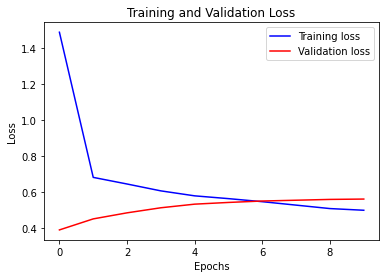

In [20]:
def visualize_loss(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs=range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label= 'Training loss')
  plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

visualize_loss(history, 'Training and Validation Loss')

## Prediction

Now finally, we are going to make predictions with the model we trained above. Below we are making predictions for 5 set of values from the validation set. 

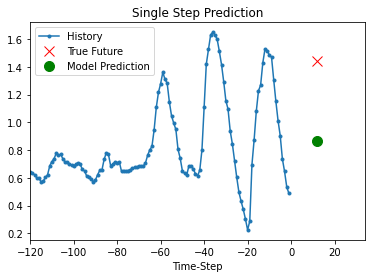

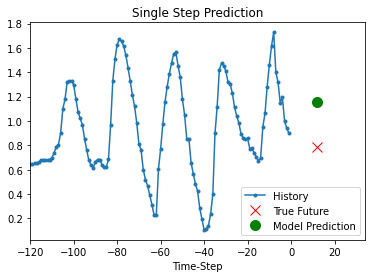

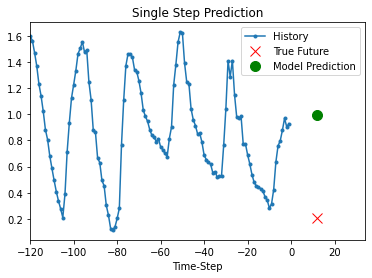

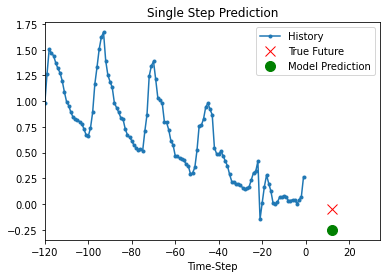

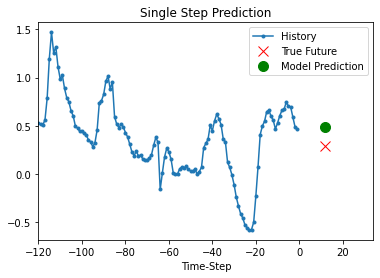

In [21]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = list(range(-(plot_data[0].shape[0]), 0))
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  plt.show()
  return

for x, y in val_repeat_data.take(5):
  show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 12,
                   'Single Step Prediction')